Testing Curvenlinops for the calculation of: 
 
 $\alpha^*=\frac{-d^{\top} g}{d^{\top} H d}$

In [7]:
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torch.nn.utils import vector_to_parameters  # this is NOT inverse of params_to_vector, see cell below
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from warnings import warn
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from tueplots import axes, bundles, fonts, fontsizes, figsizes  # for consistent plotting

#sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..', '..'))) 
from curvlinops import GGNLinearOperator, HessianLinearOperator
from curvlinops.examples.functorch import functorch_ggn, functorch_hessian
from curvlinops.examples.utils import report_nonclose
import sys
from source.plotting import plot_data, get_style



# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:06<00:00, 1500792.48it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 294760.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1319095.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1294017.71it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Load the jmlr2001 style
# jmlr_style = bundles.jmlr2001()

Defining the method for vector -> Parameter list (iterable):

In [8]:
def vector_to_parameter_list(vec, parameters):
    """Convert the vector `vec` to a parameter-list format matching
    `parameters`. This function is the inverse of `parameters_to_vector` from
    `torch.nn.utils`. In contrast to `vector_to_parameters`, which replaces the
    value of the parameters, this function leaves the parameters unchanged and
    returns a list of parameter views of the vector.

    Args:
        vec (torch.Tensor): The vector representing the parameters. This vector
            is converted to a parameter-list format matching `parameters`.
        parameters (iterable): An iterable of `torch.Tensor`s containing the
            parameters. These parameters are not changed by the function.

    Raises:
        Warning if not all entries of `vec` are converted.
    """

    if not isinstance(vec, torch.Tensor):
        raise TypeError(f"`vec` should be a torch.Tensor, not {type(vec)}.")

    # Put slices of `vec` into `params_list`
    params_list = []
    pointer = 0
    for param in parameters:
        num_param = param.numel()
        params_list.append(
            vec[pointer: pointer + num_param].view_as(param).data
        )
        pointer += num_param

    # Make sure all entries of the vector have been used (i.e. that `vec` and
    # `parameters` have the same number of elements)
    if pointer != len(vec):
        warn("Not all entries of `vec` have been used.")

    return params_list

Defining a simple network:

In [2]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),  # Input size is 784 (28x28), hidden layer size is 128
            nn.ReLU(),
            nn.Linear(128, 64),   # Second hidden layer size is 64
            nn.ReLU(),
            nn.Linear(64, 10)     # Output layer for 10 classes
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = SimpleNet()

Defining the "train" method (including curvature calculations):

In [3]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    alpha_values = []  # store the alpha values
    loss_values = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)   # daten müssen auf "device" (zB cpu oder cuda) geladen werden
        
        # save current parameters
        theta_0 = parameters_to_vector(model.parameters())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        loss.backward()
        
        Data = [(data, target)]                                        # expected by curvelinops
        params = [p for p in model.parameters() if p.requires_grad]    # expected by curvelinops
        
        
        GGN = GGNLinearOperator(model, criterion, params, Data) # GGN stores linear operator for multiplication
        
         # Extract gradients and convert to a vector
        gradients = parameters_to_vector(param.grad for param in model.parameters() if param.grad is not None)
        
        optimizer.step()
        
        
        d_unnormalized = parameters_to_vector(model.parameters()) - theta_0 # direction of adjustment
        
        d_normalized = d_unnormalized / torch.norm(d_unnormalized)          # normalized direction of adjustment
        
        GGNd = GGN @ d_unnormalized.detach().numpy()  # Multiply GGN * d, outputs np array
        
        
        GGNd_tensor = torch.tensor(GGNd)
        
        dGGNd = torch.dot(GGNd_tensor, d_unnormalized)
        
        dg = - torch.dot(gradients, d_unnormalized)  # numerator: - d^T*g
        
        alpha = dg / dGGNd
        
        alpha_values.append(alpha)
        
        loss_values.append(loss.item())
        
        position = 0 # only for printing, I print different positions of the data each time
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            print("alpha values length: ", len(alpha_values))
            
        
    # Convert alpha values from list to a tensor
    alpha_values_tensor = torch.tensor(alpha_values)
    loss_tensor = torch.tensor(loss_values)
    
    # Split alpha and loss values into chunks of size 10
    alpha_chunks = torch.split(alpha_values_tensor, 10)
    loss_chunks = torch.split(loss_tensor, 10)


    # Filter out the last chunk if its length is less than 10
    if len(alpha_chunks[-1]) < 5:
        alpha_chunks = alpha_chunks[:-1]  # Drop the last chunk
    if len(loss_chunks[-1]) < 5:
        loss_chunks = loss_chunks[:-1]    # Drop the last chunk
    
    # Calculate average alpha values for each chunk, this gives back a list
    avg_alpha_values = [chunk.mean() for chunk in alpha_chunks]
    avg_loss_values = [chunk.mean() for chunk in loss_chunks]

       
    
    # convert back to tensor
    avg_alpha_values_tensor = torch.tensor(avg_alpha_values)
    avg_loss_values_tensor = torch.tensor(avg_loss_values)

    
    
    return alpha_values_tensor, loss_tensor, avg_alpha_values_tensor, avg_loss_values_tensor
    
    
        
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
            

Set device, move model, set opimizer and loss (criterion)

In [4]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model.to(device)

# Set up optimizer and loss function
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [5]:
num_epochs = 3
# store over multiple epochs
complete_alphas = []
complete_loss = []
complete_avg_alphas =[]
complete_avg_losses = []
# Training and testing loop
for epoch in range(1, num_epochs + 1):
    
    alpha_values_tensor, loss_tensor, avg_alpha_values_tensor, avg_loss_values_tensor = train(model, device, train_loader, optimizer, criterion, epoch)
    complete_alphas.append(alpha_values_tensor)
    complete_loss.append(loss_tensor)
    complete_avg_alphas.append(avg_alpha_values_tensor)
    complete_avg_losses.append(avg_loss_values_tensor)
    
    test(model, device, test_loader, criterion)
    

NameError: name 'train_loader' is not defined

In [ ]:
import warnings

# Check the lengths
original_length = sum(len(epoch) for epoch in complete_alphas)
expected_length = original_length // 10
print(expected_length)

# Print the lengths
print(f"Original alpha tensor length: {sum(len(epoch) for epoch in complete_alphas)}")
print(f"Original loss tensor length: {sum(len(epoch) for epoch in complete_loss)}")
print(f"Avg alpha tensor length: {sum(len(epoch) for epoch in complete_avg_alphas)}")
print(f"Avg loss tensor length: {sum(len(epoch) for epoch in complete_avg_losses)}")

# Raise warning if avg length deviates by more than +/- 1
if abs(sum(len(epoch) for epoch in complete_avg_alphas) - expected_length) > num_epochs:
    warnings.warn(f"Avg alpha tensor length is more than +/-1 off: {sum(len(epoch) for epoch in complete_avg_alphas)}")

if abs(sum(len(epoch) for epoch in complete_avg_losses) - expected_length) > num_epochs:
    warnings.warn(f"Avg loss tensor length is more than +/-1 off: {sum(len(epoch) for epoch in complete_avg_losses)}")

562
Original alpha tensor length: 5625
Original loss tensor length: 5625
Avg alpha tensor length: 564
Avg loss tensor length: 564


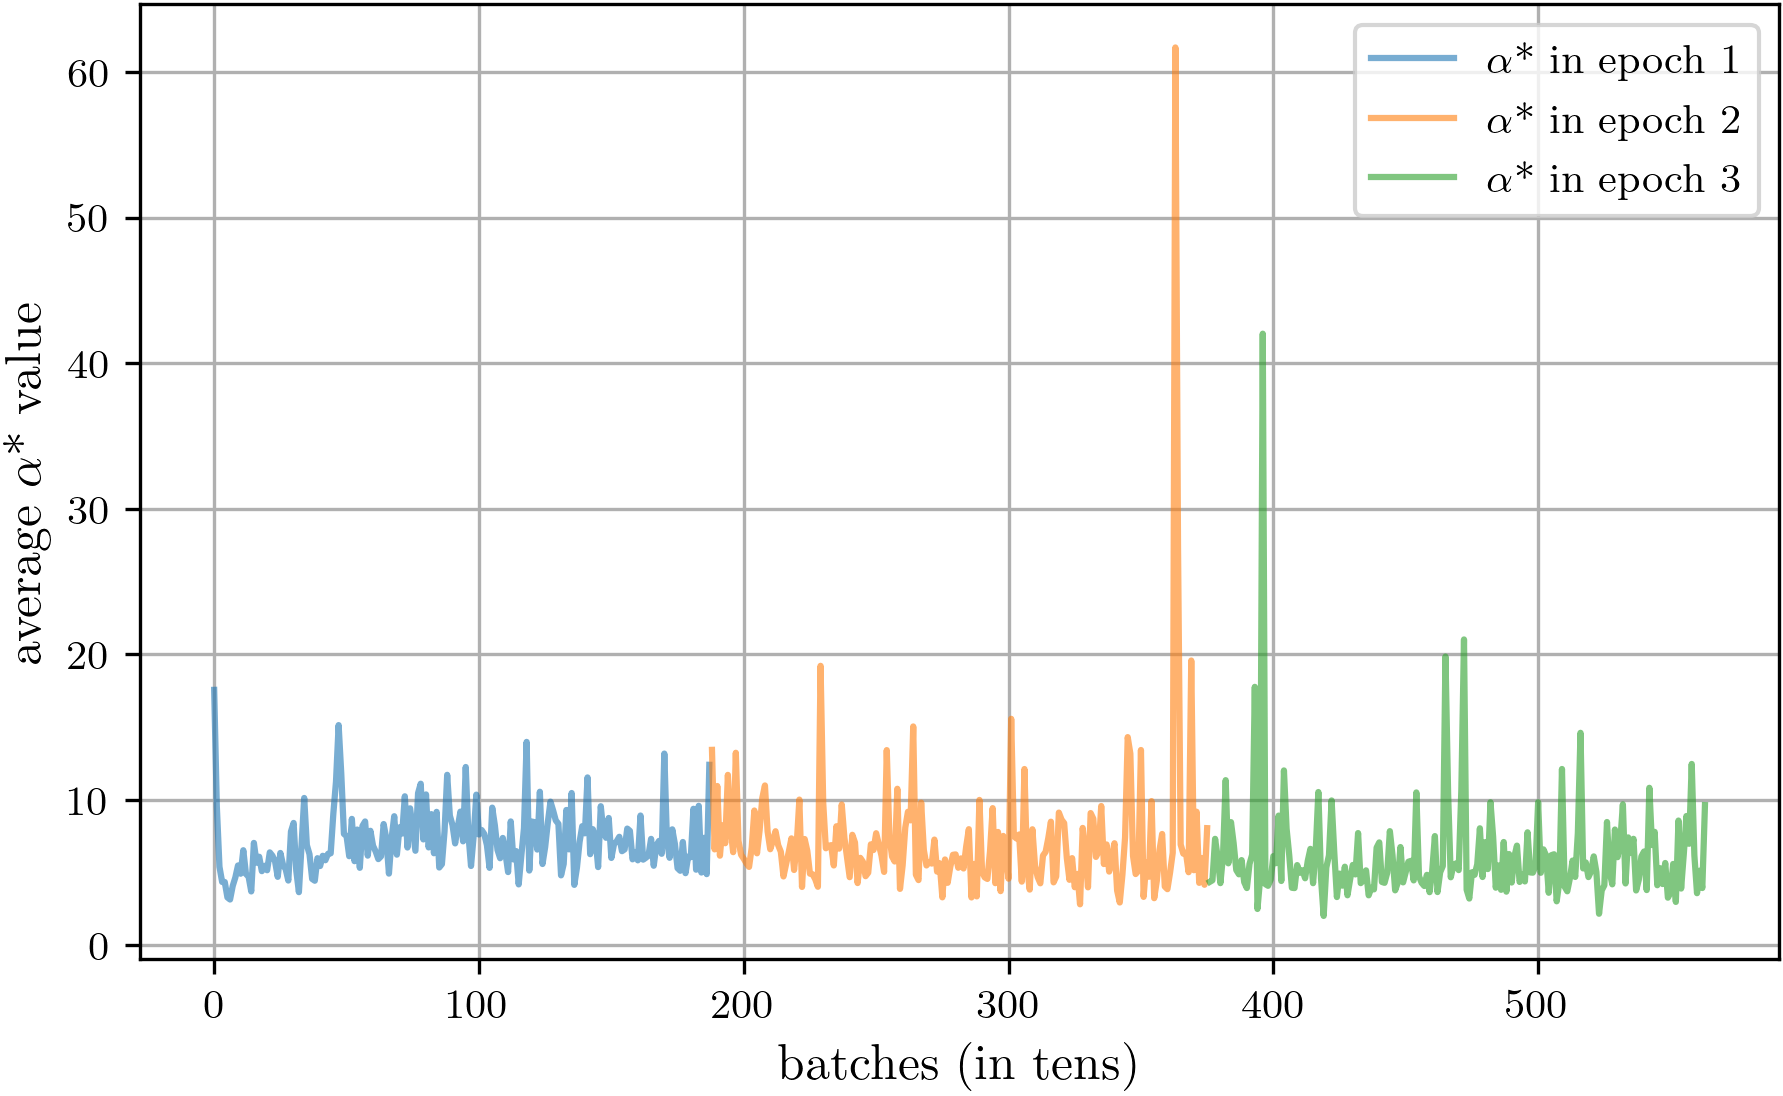

In [ ]:


# plot avg alphas data
plot_data(complete_avg_alphas[:3], [], "large","batches (in tens)" ,r'average $\alpha$* value', use_legend=True, legend_labels=[r'$\alpha$* in epoch 1',
                                                                                                            r'$\alpha$* in epoch 2',
                                                                                                              r'$\alpha$* in epoch 3'], 
                                                                                                              concat_data= True, horizontal=False
                                                                                                              ,font_adj=1)

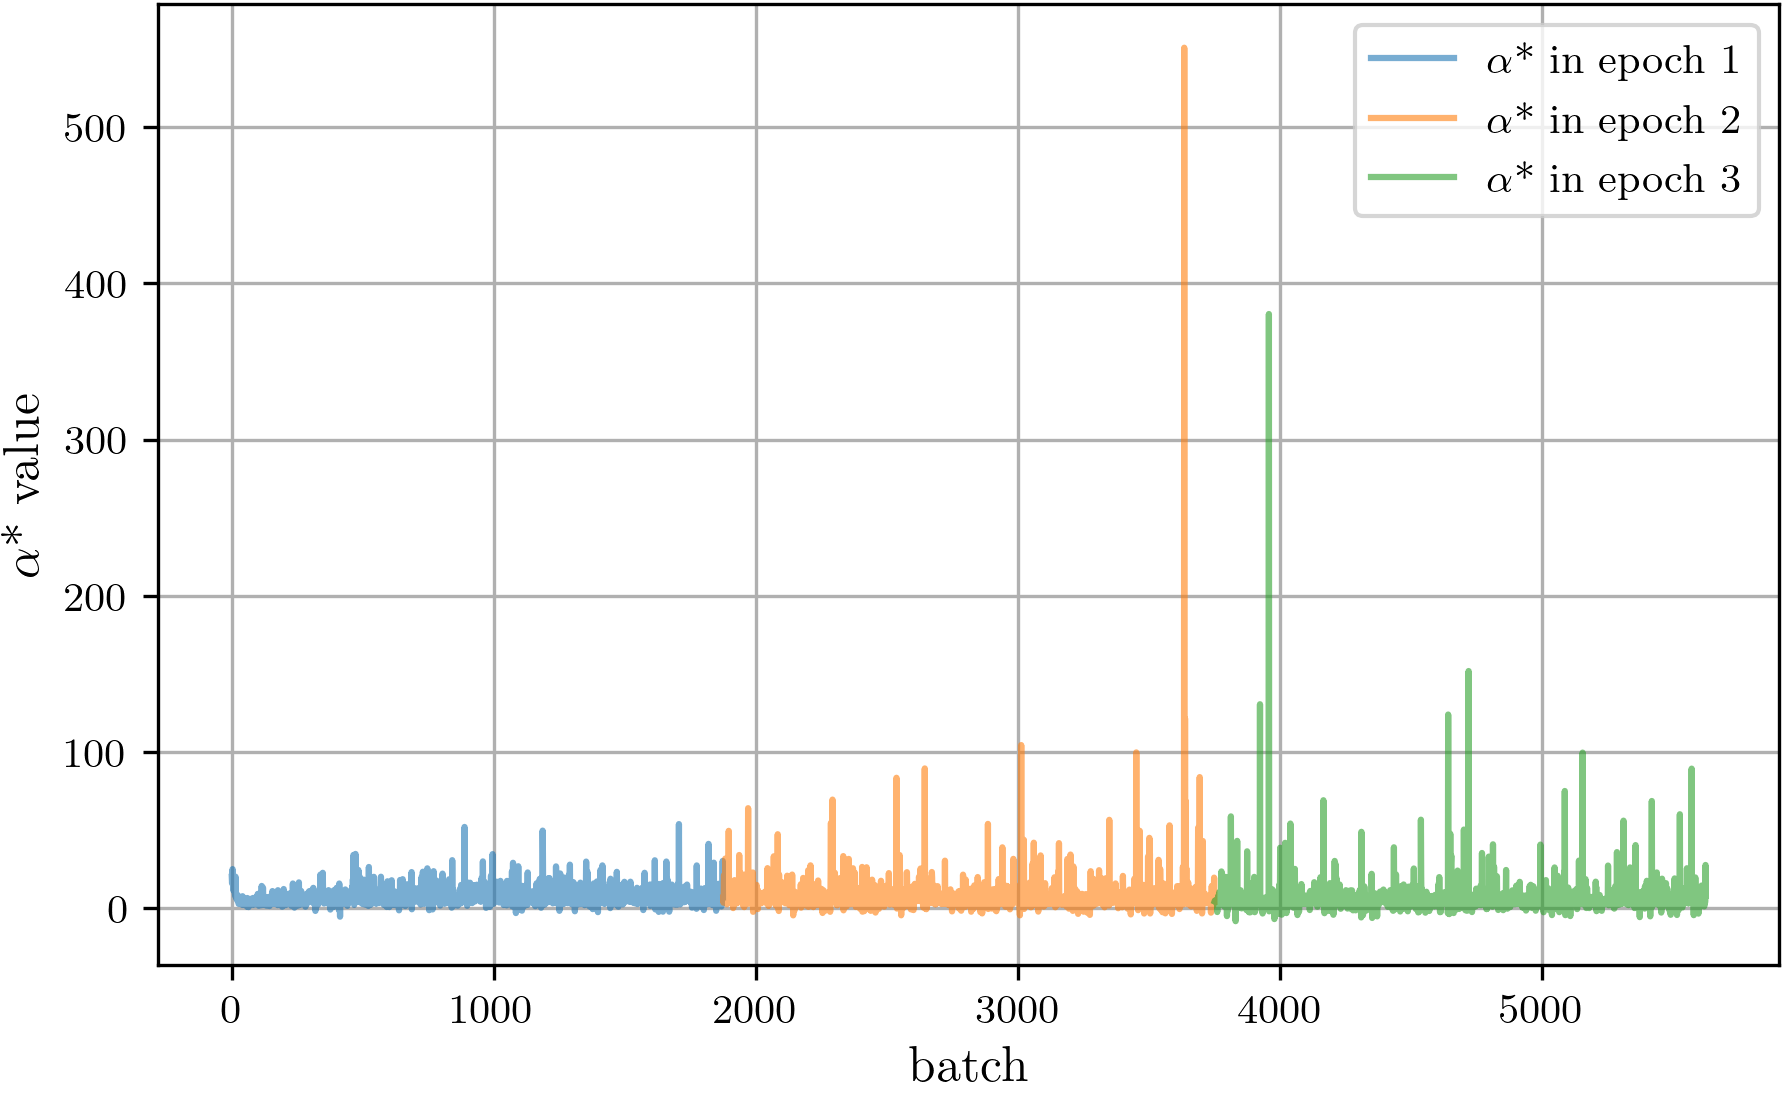

In [ ]:
# plot raw alphas
plot_data(complete_alphas[:3], [], "large","batch" ,r'$\alpha$* value', use_legend=True, legend_labels=[r'$\alpha$* in epoch 1',
                                                                                                            r'$\alpha$* in epoch 2',
                                                                                                              r'$\alpha$* in epoch 3'], 
                                                                                                              concat_data= True, horizontal=False
                                                                                                              ,font_adj=1)

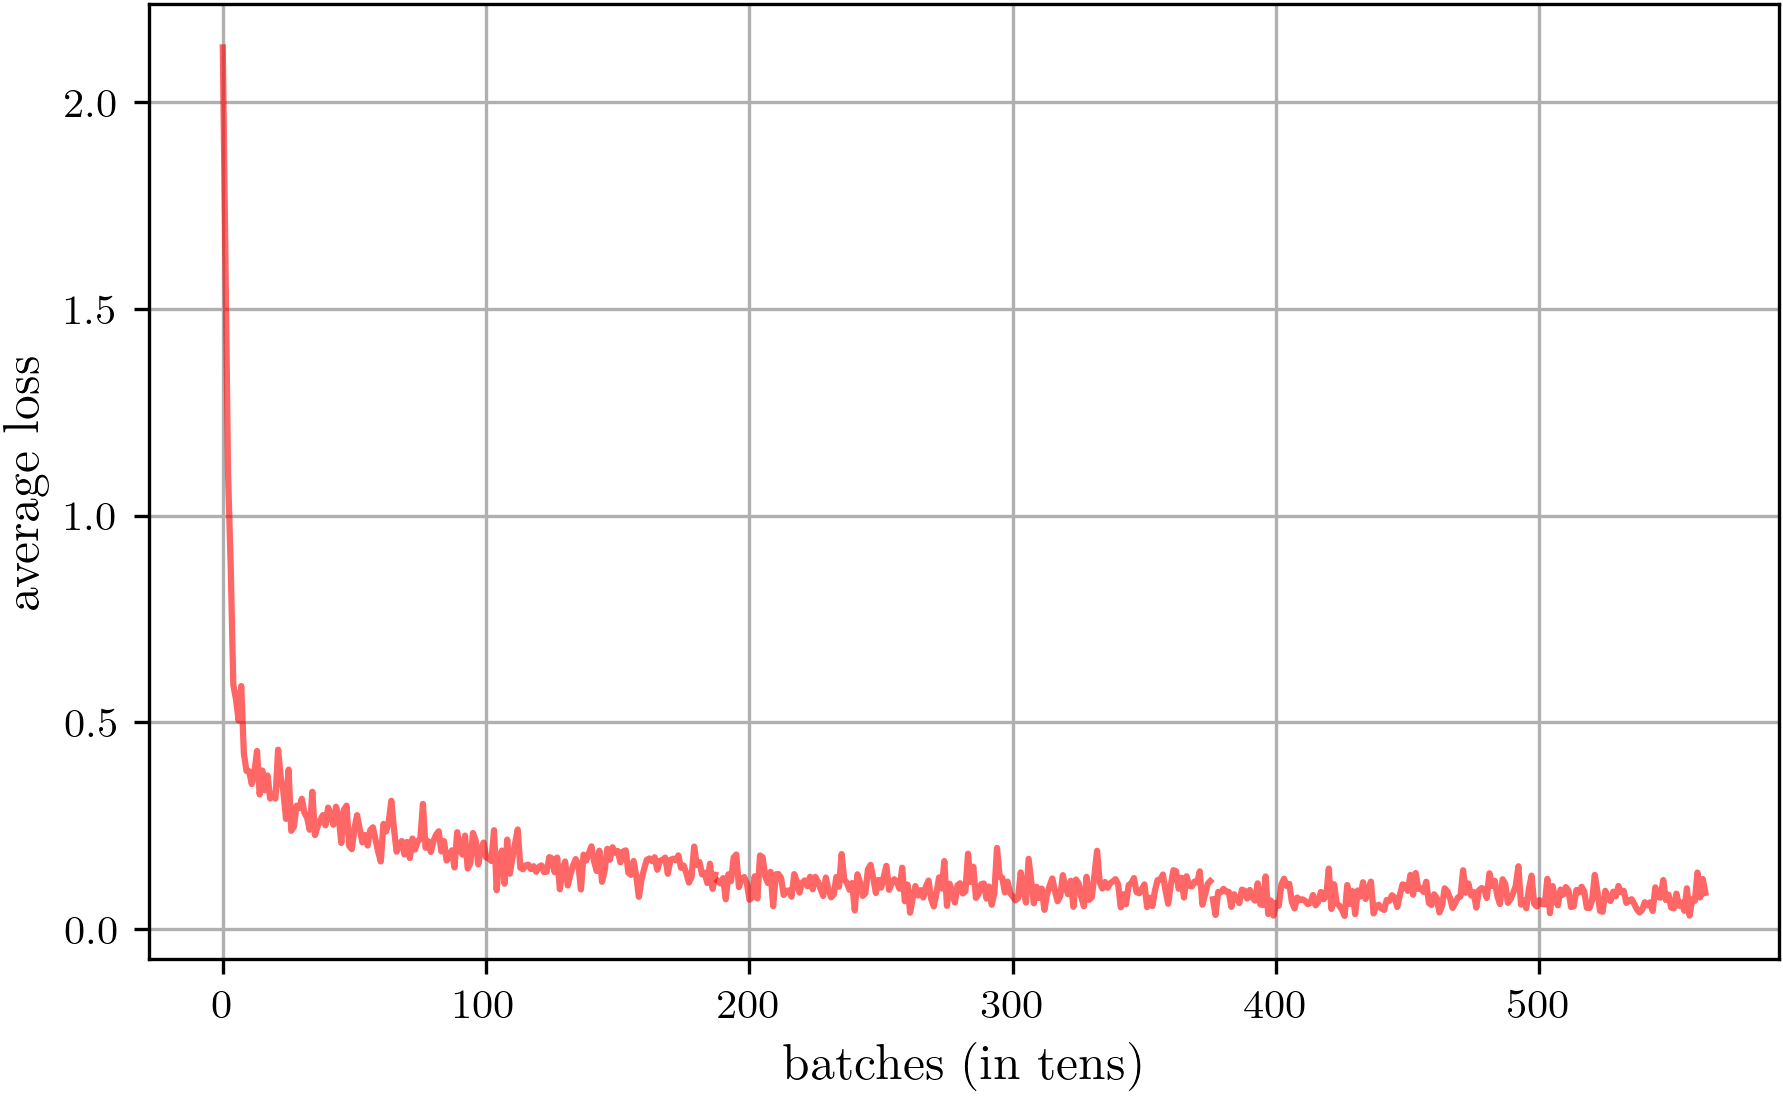

In [ ]:
# plot avg loss
plot_data(complete_avg_losses[:3],['r','r','r'], "large", "batches (in tens)", "average loss", concat_data = True, use_legend=False,font_adj=1,
          horizontal=False)

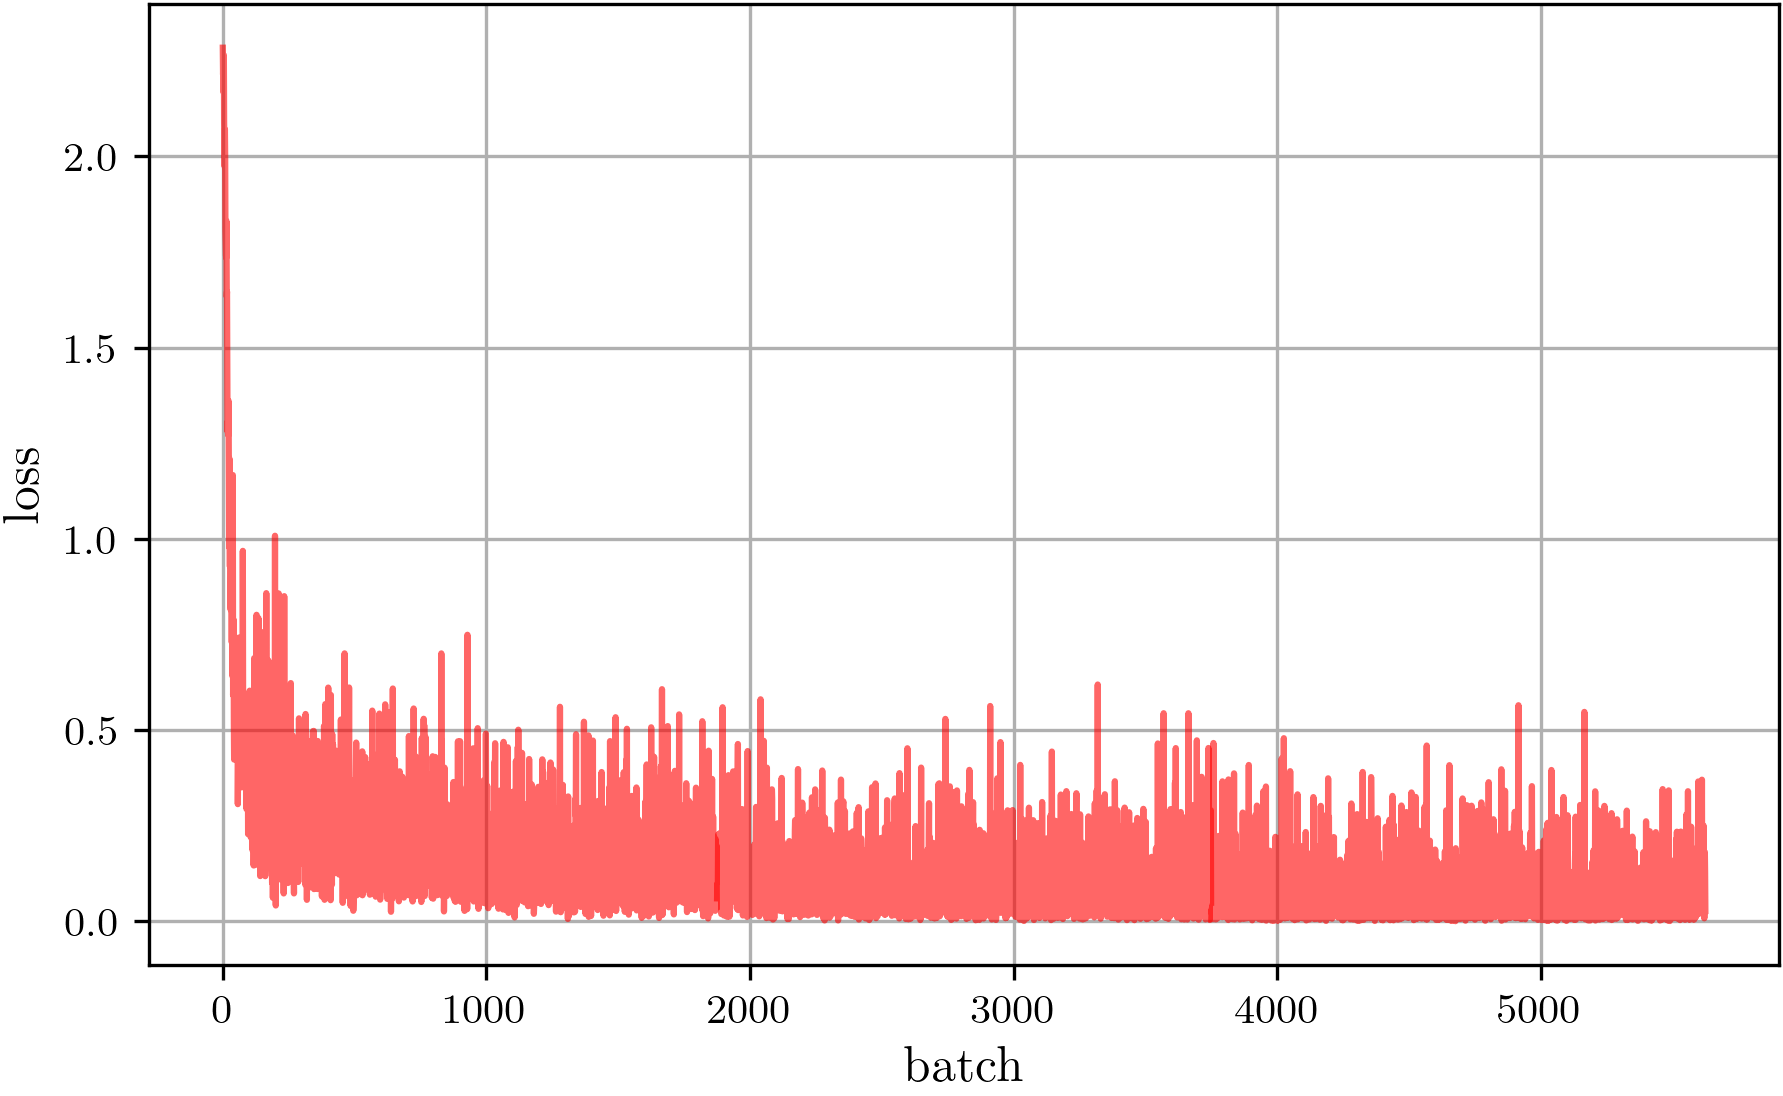

In [ ]:
# plot complete
plot_data(complete_loss[:3],['r','r','r'], "large", "batch", "loss", concat_data = True, use_legend=False,font_adj=1,
          horizontal=False)

In [ ]:
import numpy as np
import torch 


import pandas as pd
import numpy as np
# compute std dev, variance, mean and max/min
def calculate_statistics(data, output_file="statistics_table.csv"):
    # Initialize lists to hold epoch-wise statistics
    epoch_means = []
    epoch_variances = []
    epoch_std_devs = []
    epoch_maximums = []
    epoch_minimums = []

    # Flatten the list of tensors into a single list and calculate epoch statistics
    all_values = []
    for epoch in data:
        # Create a list to hold the values for the current epoch
        epoch_values = []
        for value in epoch:
            # Convert scalar tensors to 1D arrays
            if value.dim() == 0:  # Check if it's a scalar tensor
                epoch_values.append(np.array([value.item()]))  # Convert scalar to 1D array
            else:
                epoch_values.append(value.detach().numpy())  # Convert to NumPy array

        # Now flatten the epoch_values list
        epoch_values = np.concatenate(epoch_values)

        # Calculate statistics for the current epoch
        epoch_means.append(np.mean(epoch_values))
        epoch_variances.append(np.var(epoch_values))
        epoch_std_devs.append(np.std(epoch_values))
        epoch_maximums.append(np.max(epoch_values))
        epoch_minimums.append(np.min(epoch_values))

        # Append the epoch values to the all_values list for overall statistics
        all_values.extend(epoch_values)

    # Convert all_values to a NumPy array for combined statistics
    all_values_np = np.array(all_values)

    print("Length:", len(all_values_np))
    # Calculate overall statistics
    combined_mean = np.mean(all_values_np)
    combined_variance = np.var(all_values_np)
    combined_std_dev = np.std(all_values_np)
    combined_maximum = np.max(all_values_np)
    combined_minimum = np.min(all_values_np)

    

    # Create a dictionary to hold the data
    stats_dict = {
        "Epoch": list(range(1, len(epoch_means) + 1)) + ["Combined"],
        "Mean": epoch_means + [combined_mean],
        "Variance": epoch_variances + [combined_variance],
        "Standard Deviation": epoch_std_devs + [combined_std_dev],
        "Maximum": epoch_maximums + [combined_maximum],
        "Minimum": epoch_minimums + [combined_minimum]
    }

    # Convert dictionary to a Pandas DataFrame for easier export
    df = pd.DataFrame(stats_dict)

    # Save the DataFrame as a CSV file
    df.to_csv(output_file, index=False)

    # Return the statistics as a dictionary
    return {
        "combined": {
            "mean": combined_mean,
            "variance": combined_variance,
            "std_dev": combined_std_dev,
            "maximum": combined_maximum,
            "minimum": combined_minimum
        },
        "epoch": {
            "means": epoch_means,
            "variances": epoch_variances,
            "std_devs": epoch_std_devs,
            "maximums": epoch_maximums,
            "minimums": epoch_minimums
        }
    }


# Calculate statistics for each list
statistics = calculate_statistics(complete_alphas)

# Print the results
print("Combined Statistics:")
print("Mean:", statistics["combined"]["mean"])
print("Variance:", statistics["combined"]["variance"])
print("Std Dev:", statistics["combined"]["std_dev"])
print("Maximum:", statistics["combined"]["maximum"])
print("Minimum:", statistics["combined"]["minimum"])  # Print minimum for combined

print("\nEpoch-wise Statistics:")
for i in range(len(statistics["epoch"]["means"])):
    print(f"Epoch {i + 1}: Mean:", statistics["epoch"]["means"][i],
          "Variance:", statistics["epoch"]["variances"][i],
          "Std Dev:", statistics["epoch"]["std_devs"][i],
          "Maximum:", statistics["epoch"]["maximums"][i],
          "Minimum:", statistics["epoch"]["minimums"][i])  # Print minimum for each epoch


Length: 5625
Combined Statistics:
Mean: 6.8480762652473315
Variance: 135.2854324462648
Std Dev: 11.63122660970307
Maximum: 550.877197265625
Minimum: -8.346722602844238

Epoch-wise Statistics:
Epoch 1: Mean: 7.1771913143118224 Variance: 25.254437670527082 Std Dev: 5.025379355882208 Maximum: 53.81717300415039 Minimum: -5.461832523345947
Epoch 2: Mean: 7.225749079654614 Variance: 227.39943064398153 Std Dev: 15.07976891878591 Maximum: 550.877197265625 Minimum: -4.620514869689941
Epoch 3: Mean: 6.141288401775559 Variance: 152.45192647007167 Std Dev: 12.347142441474936 Maximum: 380.3823547363281 Minimum: -8.346722602844238


In [ ]:
# save raw data for later

torch.save(complete_alphas, 'complete_alphas.pt')
torch.save(complete_loss, 'complete_loss.pt')
torch.save(complete_avg_alphas, 'complete_avg_alphas.pt')
torch.save(complete_avg_losses, 'complete_avg_losses.pt')


In [ ]:
# Print the lengths for check
print("Length of alpha_values_tensor:", len(alpha_values_tensor))
print("Length of avg_alpha_values_tensor:", len(avg_alpha_values_tensor))
print("Length of avg_loss_values_tensor:", len(avg_loss_values_tensor))
print(len(complete_alphas))  # expect n for n epochs
print(len(complete_loss))   
print(len(complete_avg_alphas))  
print(len(complete_avg_losses))

Length of alpha_values_tensor: 1875
Length of avg_alpha_values_tensor: 188
Length of avg_loss_values_tensor: 188
3
3
3
3


In [ ]:
# (old) custom plotting function

def plot_results(complete_alphas, complete_losses):
    """ 
    Takes lists of alphas and losses for each epoch and plots them.
    """
    jmlr_style = get_style()
    
    with plt.rc_context(jmlr_style):
        plt.figure()

        # Initialize the starting index for x-values
        start_index = 0
        
        # Plot alpha values for each epoch
        for epoch_idx, alphas in enumerate(complete_alphas):
            # Convert the current epoch alphas to numpy for plotting
            alphas_np = np.array([a.detach().numpy() for a in alphas])  # Detach if they're tensors
            
            # Create x-values for the current epoch
            x_values = np.arange(start_index, start_index + len(alphas_np))
            
            # Plot alpha values for the current epoch
            plt.plot(x_values, alphas_np, label=f'Alpha in Epoch {epoch_idx + 1}', alpha=0.6)
            
            # Update the starting index for the next epoch
            start_index += len(alphas_np)

        # Plot losses
        # losses_flattened = [loss for sublist in complete_losses for loss in sublist]
        # x_losses = np.arange(len(losses_flattened))  # x-values for losses
        # plt.plot(x_losses, losses_flattened, label='Loss', color='red', linewidth=2)

        # Adding details to the plot
        plt.xlabel("10 Batches")
        plt.ylabel(r'$\alpha$* Value')
        plt.axhline(0, color='black', lw=0.8, ls='--')  # Add a horizontal line at y=0 for reference
        plt.legend()
        plt.grid(True)
        # Adding explanation below the plot using figtext
        plt.savefig('plot.pdf')  # dpi=300 ensures good quality

    
        plt.show()